## Adaptive RAG 

In [1]:
import os
from dotenv import load_dotenv
load_dotenv() ## aloading all the environment variable

# os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")
os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")

In [2]:
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter

ModuleNotFoundError: No module named 'langchain_community'

In [ ]:
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter

urls = [
    "https://en.wikipedia.org/wiki/Economy_of_India",
    "https://en.wikipedia.org/wiki/Artificial_intelligence",
    "https://en.wikipedia.org/wiki/Impact_of_artificial_intelligence_on_labor_market",
    "https://en.wikipedia.org/wiki/Stock_market",
    "https://en.wikipedia.org/wiki/Digital_transformation"
]

docs = [WebBaseLoader(url).load() for url in urls]
len(docs), docs[:1]  # check number of docs and preview first


ModuleNotFoundError: No module named 'langchain_community'

In [3]:
doc_list=[item for sublist in docs for item in sublist]
doc_list

[Document(metadata={'source': 'https://en.wikipedia.org/wiki/Economy_of_India', 'title': 'Economy of India - Wikipedia', 'language': 'en'}, page_content='\n\n\n\nEconomy of India - Wikipedia\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nJump to content\n\n\n\n\n\n\n\nMain menu\n\n\n\n\n\nMain menu\nmove to sidebar\nhide\n\n\n\n\t\tNavigation\n\t\n\n\nMain pageContentsCurrent eventsRandom articleAbout WikipediaContact us\n\n\n\n\n\n\t\tContribute\n\t\n\n\nHelpLearn to editCommunity portalRecent changesUpload fileSpecial pages\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nSearch\n\n\n\n\n\n\n\n\n\n\n\nSearch\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nAppearance\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nDonate\n\nCreate account\n\nLog in\n\n\n\n\n\n\n\n\nPersonal tools\n\n\n\n\n\nDonate Create account Log in\n\n\n\n\n\n\t\tPages for logged out editors learn more\n\n\n\nContributionsTalk\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nContents\nmove to sidebar\nhide\n\n\n

In [4]:
len(doc_list)

5

In [5]:
text_splitter=RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=1000,chunk_overlap=100
)

doc_split=text_splitter.split_documents(doc_list)

#Add to VectorDB
vectorstore=FAISS.from_documents(
    documents=doc_split,
    embedding=OpenAIEmbeddings()
)
retriever=vectorstore.as_retriever()

In [6]:
retriever.invoke("how to invest in stock market?")

[Document(id='0292a86e-8d2c-4ca4-8029-dcb2d31d78fc', metadata={'source': 'https://en.wikipedia.org/wiki/Stock_market', 'title': 'Stock market - Wikipedia', 'language': 'en'}, page_content='Investment strategies\nMain articles: Investment strategy, Stock market prediction, and Investment management\nMany strategies can be classified as either fundamental analysis or technical analysis. Fundamental analysis refers to analyzing companies by their financial statements found in SEC filings, business trends, and general economic conditions. Technical analysis studies price actions in markets through the use of charts and quantitative techniques to attempt to forecast price trends based on historical performance, regardless of the company\'s financial prospects. One example of a technical strategy is the Trend following method, used by John W. Henry and Ed Seykota, which uses price patterns and is also rooted in risk management and diversification.\nAdditionally, many choose to invest via pas

In [4]:
### Router

from typing import Literal

from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI

from pydantic import BaseModel, Field

# Data Model
class RouteQuery(BaseModel):
    """Route a user query to the most relevant datasource"""
    
    datasource:Literal["vectorstore","web_search"]=Field(
        description="Given a user question choose to route it to web search or a vectorstore."
    )

# LLM with function call
llm=ChatOpenAI(model="gpt-4o-mini",temperature=0)
structured_llm_router=llm.with_structured_output(RouteQuery)


#Prompt
system="""

You are an expert at routing a user's question to the correct datasource.

You have access to two datasources:
1. **vectorstore** → contains Wikipedia documents related to:
   - Economy of India
   - Artificial Intelligence
   - Impact of AI on the labor market
   - Stock Market
   - Digital Transformation
2. **web_search** → for all other topics not covered above.

Instructions:
- If the question is clearly about any of the five topics above, choose **vectorstore**.
- Otherwise, choose **web_search**.

Return only one word: either `vectorstore` or `web_search`.


"""

route_prompt=ChatPromptTemplate.from_messages(
    [
        ("system",system),
        ("human","{question}"),
    ]
)

question_router=route_prompt|structured_llm_router

print(question_router.invoke({"question":"what is Artificial intelligence ?"}))

ModuleNotFoundError: No module named 'langchain_openai'

In [14]:
### Retrieval Grader


# Data model
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )


# LLM with function call
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
structured_llm_grader = llm.with_structured_output(GradeDocuments)

# Prompt
system = """You are a grader assessing relevance of a retrieved document to a user question. \n 
    If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
    It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)

retrieval_grader = grade_prompt | structured_llm_grader
question = "what is Artificial intelligence ?"
docs = retriever.invoke(question)
doc_txt = docs[1].page_content
print(retrieval_grader.invoke({"question": question, "document": doc_txt}))

binary_score='yes'


In [15]:
docs

[Document(id='5288796b-f5b7-4799-b4f2-8d141a9a821e', metadata={'source': 'https://en.wikipedia.org/wiki/Artificial_intelligence', 'title': 'Artificial intelligence - Wikipedia', 'language': 'en'}, page_content='Edit links\n\n\n\n\n\n\n\n\n\n\n\nArticleTalk\n\n\n\n\n\nEnglish\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nReadView sourceView history\n\n\n\n\n\n\n\nTools\n\n\n\n\n\nTools\nmove to sidebar\nhide\n\n\n\n\t\tActions\n\t\n\n\nReadView sourceView history\n\n\n\n\n\n\t\tGeneral\n\t\n\n\nWhat links hereRelated changesUpload filePermanent linkPage informationCite this pageGet shortened URLDownload QR code\n\n\n\n\n\n\t\tPrint/export\n\t\n\n\nDownload as PDFPrintable version\n\n\n\n\n\n\t\tIn other projects\n\t\n\n\nWikimedia CommonsMeta-WikiWikibooksWikinewsWikiquoteWikiversityWikidata item\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nAppearance\nmove to sidebar\nhide\n\n\n\n\n\n\n\n\n\n\n\nFrom Wikipedia, the free encyclopedia\n\n\nIntelligence of machines\n"AI" redirects here. For other uses

In [17]:
### Generate

from langchain import hub
from langchain_core.output_parsers import StrOutputParser
question = "Artificial neural networks"

# Prompt
prompt = hub.pull("rlm/rag-prompt")

# LLM
llm = ChatOpenAI(model_name="gpt-4o-mini", temperature=0)


# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


# Chain
rag_chain = prompt | llm | StrOutputParser()

# Run
generation = rag_chain.invoke({"context": docs, "question": question})
print(generation)

Artificial neural networks are a key technique in artificial intelligence, particularly within the subfield of machine learning. They are designed to simulate the way human brains operate, allowing machines to learn from data and improve their performance over time. This approach has gained significant traction, especially with the rise of deep learning and advancements in computational power.


In [18]:
### Hallucination Grader


# Data model
class GradeHallucinations(BaseModel):
    """Binary score for hallucination present in generation answer."""

    binary_score: str = Field(
        description="Answer is grounded in the facts, 'yes' or 'no'"
    )


# LLM with function call
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
structured_llm_grader = llm.with_structured_output(GradeHallucinations)

# Prompt
system = """You are a grader assessing whether an LLM generation is grounded in / supported by a set of retrieved facts. \n
     Give a binary score 'yes' or 'no'. 'Yes' means that the answer is grounded in / supported by the set of facts."""
hallucination_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Set of facts: \n\n {documents} \n\n LLM generation: {generation}"),
    ]
)

hallucination_grader = hallucination_prompt | structured_llm_grader
hallucination_grader.invoke({"documents": docs, "generation": generation})

GradeHallucinations(binary_score='yes')

In [19]:
### Answer Grader


# Data model
class GradeAnswer(BaseModel):
    """Binary score to assess answer addresses question."""

    binary_score: str = Field(
        description="Answer addresses the question, 'yes' or 'no'"
    )


# LLM with function call
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
structured_llm_grader = llm.with_structured_output(GradeAnswer)

# Prompt
system = """You are a grader assessing whether an answer addresses / resolves a question \n
     Give a binary score 'yes' or 'no'. Yes' means that the answer resolves the question."""
answer_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "User question: \n\n {question} \n\n LLM generation: {generation}"),
    ]
)

answer_grader = answer_prompt | structured_llm_grader
answer_grader.invoke({"question": question, "generation": generation})

GradeAnswer(binary_score='yes')

In [20]:
### Question Re-writer

# LLM
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
 
# Prompt
system = """You a question re-writer that converts an input question to a better version that is optimized \n
     for vectorstore retrieval. Look at the input and try to reason about the underlying semantic intent / meaning."""
re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        (
            "human",
            "Here is the initial question: \n\n {question} \n Formulate an improved question.",
        ),
    ]
)

question_rewriter = re_write_prompt | llm | StrOutputParser()
question_rewriter.invoke({"question": question})

'What are artificial neural networks and how do they function in machine learning?'

In [2]:
!pip install python-dotenv

  Using cached python_dotenv-1.1.1-py3-none-any.whl.metadata (24 kB)
Using cached python_dotenv-1.1.1-py3-none-any.whl (20 kB)



[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: C:\Users\sanat\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [3]:
import os
from dotenv import load_dotenv
from langchain_community.tools.tavily_search import TavilySearchResults

# Load variables from .env file into environment
load_dotenv()

# Now os.environ["TAVILY_API_KEY"] is available
web_search_tool = TavilySearchResults(k=3)


ModuleNotFoundError: No module named 'langchain_community'

In [22]:
from typing import List

from typing_extensions import TypedDict


class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        documents: list of documents
    """

    question: str
    generation: str
    documents: List[str]

In [23]:
from langchain.schema import Document


def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Retrieval
    documents = retriever.invoke(question)
    return {"documents": documents, "question": question}


def generate(state):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]

    # RAG generation
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"documents": documents, "question": question, "generation": generation}


def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]

    # Score each doc
    filtered_docs = []
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score.binary_score
        if grade == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            continue
    return {"documents": filtered_docs, "question": question}


def transform_query(state):
    """
    Transform the query to produce a better question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates question key with a re-phrased question
    """

    print("---TRANSFORM QUERY---")
    question = state["question"]
    documents = state["documents"]

    # Re-write question
    better_question = question_rewriter.invoke({"question": question})
    return {"documents": documents, "question": better_question}


def web_search(state):
    """
    Web search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """

    print("---WEB SEARCH---")
    question = state["question"]

    # Web search
    docs = web_search_tool.invoke({"query": question})
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)

    return {"documents": web_results, "question": question}


### Edges ###


def route_question(state):
    """
    Route question to web search or RAG.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("---ROUTE QUESTION---")
    question = state["question"]
    source = question_router.invoke({"question": question})
    if source.datasource == "web_search":
        print("---ROUTE QUESTION TO WEB SEARCH---")
        return "web_search"
    elif source.datasource == "vectorstore":
        print("---ROUTE QUESTION TO RAG---")
        return "vectorstore"


def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    state["question"]
    filtered_documents = state["documents"]

    if not filtered_documents:
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print(
            "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---"
        )
        return "transform_query"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"


def grade_generation_v_documents_and_question(state):
    """
    Determines whether the generation is grounded in the document and answers question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """

    print("---CHECK HALLUCINATIONS---")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]

    score = hallucination_grader.invoke(
        {"documents": documents, "generation": generation}
    )
    grade = score.binary_score

    # Check hallucination
    if grade == "yes":
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        # Check question-answering
        print("---GRADE GENERATION vs QUESTION---")
        score = answer_grader.invoke({"question": question, "generation": generation})
        grade = score.binary_score
        if grade == "yes":
            print("---DECISION: GENERATION ADDRESSES QUESTION---")
            return "useful"
        else:
            print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
            return "not useful"
    else:
        print("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
        return "not supported"

In [24]:
from langgraph.graph import END, StateGraph, START

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("web_search", web_search)  # web search
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generatae
workflow.add_node("transform_query", transform_query)  # transform_query

# Build graph
workflow.add_conditional_edges(
    START,
    route_question,
    {
        "web_search": "web_search",
        "vectorstore": "retrieve",
    },
)
workflow.add_edge("web_search", "generate")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate",
    },
)
workflow.add_edge("transform_query", "retrieve")
workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not supported": "generate",
        "useful": END,
        "not useful": "transform_query",
    },
)

# Compile
app = workflow.compile()

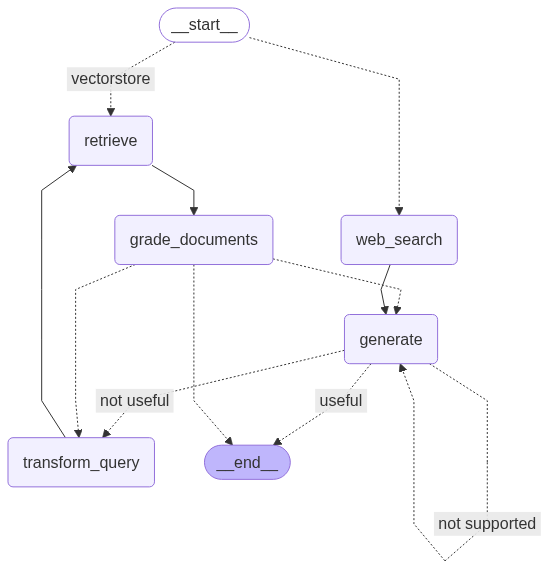

In [25]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [27]:
from pprint import pprint

# Run
inputs = {
    "question": "Why is graphics processing units (GPUs) are used in artificial intelligence?"
}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value["generation"])

---ROUTE QUESTION---
---ROUTE QUESTION TO RAG---
---RETRIEVE---
"Node 'retrieve':"
'\n---\n'
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
"Node 'grade_documents':"
'\n---\n'
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION---
"Node 'generate':"
'\n---\n'
('Graphics processing units (GPUs) are used in artificial intelligence because '
 'they are designed with AI-specific enhancements that significantly '
 'accelerate the training of large-scale machine learning models. Their '
 'parallel processing capabilities allow for faster computations compared to '
 'traditional central processing units (CPUs), making them ideal for deep '
 'learning tasks. This hardware improvement, combined wi

In [28]:
from pprint import pprint

# Run
inputs = {
    "question": "What are top AI predictions for 2026?"
}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value["generation"])

---ROUTE QUESTION---
---ROUTE QUESTION TO WEB SEARCH---
---WEB SEARCH---
"Node 'web_search':"
'\n---\n'
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION---
"Node 'generate':"
'\n---\n'
('Top AI predictions for 2026 include the strategic integration of AI '
 'technologies such as autonomous agents, memory-enabled systems, and '
 'specialized language models. There is an expectation for the emergence of '
 'artificial general intelligence (AGI), which could outperform humans in '
 'cognitive tasks, significantly impacting the job market. Additionally, AI is '
 'anticipated to automate a large percentage of tasks in various sectors, '
 'enhancing decision-making and personalizing customer experiences.')
